In [1]:
#import all the required packages
import cv2
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import winsound
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from imutils import paths
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import imutils
import tkinter as tk
import tkinter.font as font
from PIL import Image,ImageTk

In [2]:
#defining record function 

def recordVideo():
    capture = cv2.VideoCapture(0)

    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(f'recordings/{datetime.now().strftime("%H-%M-%S")}.avi', fourcc, 20.0, (640, 480))

    while True:
        ret, frame = capture.read()

        cv2.putText(frame, f'{datetime.now().strftime("%D-%H-%M-%S")}', (50, 50), cv2.FONT_HERSHEY_COMPLEX,
                    0.6, (255, 255, 255), 2)

        out.write(frame)

        cv2.imshow("esc. to stop", frame)
        
        #if Escape is pressed in between then capturing device is closed and window is destroyed
        if cv2.waitKey(1) == 27:
            capture.release()
            cv2.destroyAllWindows()
            break

loading images!!!
compiling model...
training head...
Epoch 1/30
4/4 [==============================] - 29s 7s/step - loss: 1.3626 - accuracy: 0.3984 - val_loss: 0.8555 - val_accuracy: 0.4872
Epoch 2/30
4/4 [==============================] - 5s 1s/step - loss: 0.7684 - accuracy: 0.5610 - val_loss: 0.6021 - val_accuracy: 0.7692
Epoch 3/30
4/4 [==============================] - 5s 1s/step - loss: 0.7106 - accuracy: 0.5938 - val_loss: 0.4430 - val_accuracy: 0.8718
Epoch 4/30
4/4 [==============================] - 5s 1s/step - loss: 0.4593 - accuracy: 0.7724 - val_loss: 0.3339 - val_accuracy: 0.9231
Epoch 5/30
4/4 [==============================] - 4s 1s/step - loss: 0.4135 - accuracy: 0.7886 - val_loss: 0.2589 - val_accuracy: 0.9231
Epoch 6/30
4/4 [==============================] - 4s 1s/step - loss: 0.3153 - accuracy: 0.8780 - val_loss: 0.2094 - val_accuracy: 0.9487
Epoch 7/30
4/4 [==============================] - 4s 1s/step - loss: 0.2411 - accuracy: 0.9350 - val_loss: 0.1731 - val_acc

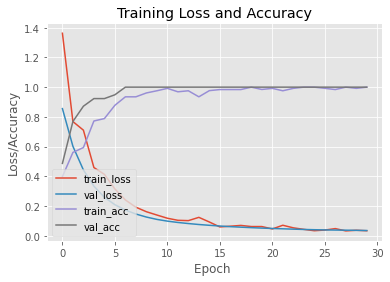

In [3]:

#Initialize batch size
batchSize=32
#Initialize number of epochs to train for
epo=30
#Initialize the initial learning rate
initlr = 1e-4

directory = r"C:\Users\NISHA KUMARI BARSHA\Dataset"
options = ["with_mask", "without_mask"]

#List of images is fetched from dataset directory. After that , list of data and label is initialized
print("loading images!!!")
data = []
labels = []

for option in options:
    location = os.path.join(directory, option)
    for pic in os.listdir(location):
        picLocation = os.path.join(location, pic)
        pics = load_img(picLocation, target_size=(224, 224))
        pics = img_to_array(pics)
        pics = preprocess_input(pics)
        data.append(pics)
        labels.append(option)

#On labels, one-hot encoding is applied
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=30)

#Construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,fill_mode="nearest")

#Let the head FC layer sets remain left off and then load the MobileNetV2 network
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

#Head of the model is being constructed
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

#Now head of the model is placed on top of base model
model = Model(inputs=baseModel.input, outputs=headModel)

#Now, iterate through the base model and make trainable false so that it won't be updated in first training process
for layer in baseModel.layers:
    layer.trainable = False

#model is compiled
print("compiling model...")
opt = Adam(lr=initlr, decay=initlr / epo)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

#head of the network is trained
print("training head...")
H = model.fit(aug.flow(trainX, trainY, batch_size=batchSize),steps_per_epoch=len(trainX) // batchSize,validation_data=(testX, testY),validation_steps=len(testX) // batchSize,epochs=epo)

#prediction
print("evaluating network...")
predIdxs = model.predict(testX, batch_size=batchSize)

#Index of label is calculated with corresponding largest predicted probability for each image present in the test set
predIdxs = np.argmax(predIdxs, axis=1)

#classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

# serialize 
print("saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

# plot the training loss and accuracy
N = epo
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch ")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [4]:

def test():
    def detect_mask(frame, faceNet, maskNet):
         # get the frame's dimension then construct a blob
        (height, width) = frame.shape[:2]
        blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
            (104.0, 177.0, 123.0))

        # pass the blob through the network and obtain the face detections
        faceNet.setInput(blob)
        detections = faceNet.forward()
        print(detections.shape)

    
        #initialize the list of faces
        faces = []
        #initialize location
        locs = []
        #initialize prediction
        preds = []

        # iterate over the detections
        for i in range(0, detections.shape[2]):
            # get the probability associated with the detection
            confidence = detections[0, 0, i, 2]

            # Exclude weak detection
            if confidence > 0.5:
                #for the object, compute coordinates of the bounding rectangular boxes
                box = detections[0, 0, i, 3:7] * np.array([width, height, width, height])
                (startX, startY, endX, endY) = box.astype("int")

                #make sure that within frame's dimension, bounding rectangular box is located
                (startX, startY) = (max(0, startX), max(0, startY))
                (endX, endY) = (min(width- 1, endX), min(height - 1, endY))
                
                #Get the face ROI then convert it from BGR to RGB then resize it to 224x224
                face = frame[startY:endY, startX:endX]
                face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                face = cv2.resize(face, (224, 224))
                face = img_to_array(face)
                face = preprocess_input(face)

                 #Into the list, add the face and bounding rectangular boxes
                faces.append(face)
                locs.append((startX, startY, endX, endY))

        #if atleast 1 face is detected then make prediction
        if len(faces) > 0:
            faces = np.array(faces, dtype="float32")
            preds = maskNet.predict(faces, batch_size=32)

        #return face location along with their corresponding prediction
        return (locs, preds)

    # from disk load serialized face detector model 
    prototxtPath = r"C:\Users\NISHA KUMARI BARSHA\deploy.prototxt"
    weightsPath = r"C:\Users\NISHA KUMARI BARSHA\res10_300x300_ssd_iter_140000.caffemodel"
    faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

    #from disk fetch the mask_detector model
    maskNet = load_model("mask_detector.model")

    # initialize the video 
    print("starting video stream...")
    vs = VideoStream(src=0).start()

    # iterate over the frames from the video
    while True:
        #resize the frame to a max width of 400 pixels after getting the frame from video
        frame = vs.read()
        frame = imutils.resize(frame, width=400)

        # detect mask
        (locs, preds) = detect_mask(frame, faceNet, maskNet)

        #iterate over the detected face locations along with their resp. prediction
        for (box, pred) in zip(locs, preds):
            (startX, startY, endX, endY) = box
            (mask, withoutMask) = pred

            #write code to add color and label for bounding rectangular box and text
            label = "Mask" if mask > withoutMask else "No Mask"
            color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

            #add probability to the label
            label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
            if mask < withoutMask:
                winsound.Beep(1000,2000)

             #display the bounding rectangular box along with the label on the output frame
            cv2.putText(frame, label, (startX, startY - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
            cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)
        # show the output frame
        cv2.imshow("Escape to stop", frame)
        key = cv2.waitKey(1) & 0xFF

        # if the `q` key was pressed, break from the loop
        if cv2.waitKey(1) == 27:
             cv2.destroyAllWindows()
             vs.stop()
             break
                
                
                

In [5]:
window = tk.Toplevel()
window.title("Smart cctv")
window.iconphoto(False, tk.PhotoImage(file='record.png'))
window.geometry('1080x760')


frame1 = tk.Frame(window)

label_title = tk.Label(frame1, text="Smart  Camera")
label_font = font.Font(size=35, weight='bold',family='Helvetica')
label_title['font'] = label_font
label_title.grid(pady=(10,10), column=2)


icon = Image.open('cctv.jpg')
icon = icon.resize((150,150),Image.ANTIALIAS)
icon = ImageTk.PhotoImage(icon)
label_icon = tk.Label(frame1, image=icon)
label_icon.grid(row=1, pady=(5,10), column=2)

button1_image = Image.open('record.png')
button1_image = button1_image.resize((50,50), Image.ANTIALIAS)
button1_image = ImageTk.PhotoImage(button1_image)

button2_image = Image.open('Detector.png')
button2_image = button2_image.resize((50,50), Image.ANTIALIAS)
button2_image = ImageTk.PhotoImage(button2_image)

button3_image = Image.open('exit.jpg')
button3_image = button3_image.resize((50,50), Image.ANTIALIAS)
button3_image = ImageTk.PhotoImage(button3_image)





# ---------------Buttons-------------------#


button_font = font.Font(size=25)

button1 = tk.Button(frame1, text='Record', height=90, width=180, fg='orange', command=recordVideo, image=button1_image, compound='left')
button1['font'] = button_font
button1.grid(row=5, pady=(20,10), column=3)

button2 = tk.Button(frame1, text='Detector', height=90, width=180, fg='green', command=test, image=button2_image, compound='left')
button2['font'] = button_font
button2.grid(row=5, pady=(20,10), column=1)


button3 = tk.Button(frame1, height=90, width=180, fg='red', command=window.quit, image=button3_image)
button3['font'] = button_font
button3.grid(row=6, pady=(20,10), column=2)

frame1.pack()
window.mainloop()
exit(0)


starting video stream...
(1, 1, 88, 7)
(1, 1, 84, 7)
(1, 1, 86, 7)
(1, 1, 87, 7)
(1, 1, 90, 7)
(1, 1, 91, 7)
(1, 1, 89, 7)
(1, 1, 90, 7)
(1, 1, 90, 7)
(1, 1, 89, 7)
(1, 1, 90, 7)
(1, 1, 88, 7)
(1, 1, 91, 7)
(1, 1, 93, 7)
(1, 1, 87, 7)
(1, 1, 89, 7)
(1, 1, 92, 7)
(1, 1, 88, 7)
(1, 1, 87, 7)
(1, 1, 91, 7)
(1, 1, 93, 7)
(1, 1, 90, 7)
(1, 1, 91, 7)
(1, 1, 92, 7)
(1, 1, 90, 7)
(1, 1, 87, 7)
(1, 1, 87, 7)
(1, 1, 90, 7)
(1, 1, 86, 7)
(1, 1, 90, 7)
(1, 1, 93, 7)
(1, 1, 94, 7)
(1, 1, 90, 7)
(1, 1, 90, 7)
(1, 1, 94, 7)
(1, 1, 89, 7)
(1, 1, 88, 7)
(1, 1, 89, 7)
(1, 1, 91, 7)
(1, 1, 89, 7)
(1, 1, 91, 7)
(1, 1, 91, 7)
(1, 1, 88, 7)
(1, 1, 89, 7)
(1, 1, 87, 7)
(1, 1, 88, 7)
(1, 1, 92, 7)
(1, 1, 90, 7)
(1, 1, 89, 7)
(1, 1, 87, 7)
(1, 1, 87, 7)
(1, 1, 93, 7)
(1, 1, 88, 7)
(1, 1, 88, 7)
(1, 1, 88, 7)
(1, 1, 87, 7)
(1, 1, 88, 7)
(1, 1, 88, 7)
(1, 1, 91, 7)
(1, 1, 93, 7)
(1, 1, 90, 7)
(1, 1, 94, 7)
(1, 1, 93, 7)
(1, 1, 95, 7)
(1, 1, 90, 7)
(1, 1, 97, 7)
(1, 1, 90, 7)
(1, 1, 93, 7)
(1, 1, 92, 7)
(1, 1, 87

(1, 1, 89, 7)
(1, 1, 89, 7)
(1, 1, 84, 7)
(1, 1, 86, 7)
(1, 1, 85, 7)
(1, 1, 85, 7)
(1, 1, 81, 7)
(1, 1, 78, 7)
(1, 1, 80, 7)
(1, 1, 82, 7)
(1, 1, 89, 7)
(1, 1, 82, 7)
(1, 1, 83, 7)
(1, 1, 86, 7)
(1, 1, 85, 7)
(1, 1, 87, 7)
(1, 1, 84, 7)
(1, 1, 90, 7)
(1, 1, 82, 7)
(1, 1, 91, 7)
(1, 1, 91, 7)
(1, 1, 86, 7)
(1, 1, 88, 7)
(1, 1, 87, 7)
(1, 1, 84, 7)
(1, 1, 83, 7)
(1, 1, 85, 7)
(1, 1, 87, 7)
(1, 1, 87, 7)
(1, 1, 88, 7)
(1, 1, 87, 7)
(1, 1, 86, 7)
(1, 1, 87, 7)
(1, 1, 89, 7)
(1, 1, 87, 7)
(1, 1, 88, 7)
(1, 1, 91, 7)
(1, 1, 86, 7)
(1, 1, 91, 7)
(1, 1, 88, 7)
(1, 1, 90, 7)
(1, 1, 83, 7)
(1, 1, 89, 7)
(1, 1, 90, 7)
(1, 1, 86, 7)
(1, 1, 86, 7)
(1, 1, 93, 7)
(1, 1, 86, 7)
(1, 1, 88, 7)
(1, 1, 89, 7)
(1, 1, 86, 7)
(1, 1, 90, 7)
(1, 1, 84, 7)
(1, 1, 84, 7)
(1, 1, 83, 7)
(1, 1, 86, 7)
(1, 1, 85, 7)
(1, 1, 89, 7)
(1, 1, 87, 7)
(1, 1, 85, 7)
(1, 1, 84, 7)
(1, 1, 88, 7)
(1, 1, 87, 7)
(1, 1, 88, 7)
(1, 1, 88, 7)
(1, 1, 88, 7)
(1, 1, 87, 7)
(1, 1, 88, 7)
(1, 1, 86, 7)
(1, 1, 88, 7)
(1, 1, 89, 7)
(1, 1,